In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# --- STEP 1: LOAD THE DATA ---
try:
    housing = pd.read_csv("housing.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'housing.csv' not found.")
    print("Please download it from https://www.kaggle.com/datasets/camnugent/california-housing-prices")
    exit()

# --- STEP 2: EXPLORE THE DATA (Minimal) ---
print("\nData Info:")
housing.info()

# --- STEP 3: DATA PREPARATION (Train/Test Split) ---

# We need a stable train/test split. A random split is fine, but it's
# better to do a "stratified" split based on median_income, as it's a
# key predictor. This ensures the test set represents the whole dataset.

# 1. Create an income category to split on (dividing by 1.5, capping at 5)
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# 2. Perform the stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# 3. Drop the 'income_cat' column as it's no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f"\nTraining set size: {len(strat_train_set)}")
print(f"Test set size: {len(strat_test_set)}")

# 4. Separate features (X) and labels (y)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


# --- STEP 4: FEATURE ENGINEERING & PREPROCESSING PIPELINE ---

# We will build a "pipeline" to automatically:
# 1. Handle missing values (Imputation)
# 2. Create new features (Feature Engineering)
# 3. Handle categorical text (One-Hot Encoding)
# 4. Scale all features (Standardization)

# To do this, we need a small custom class for feature engineering
# This is the "best practice" way to do it within a pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Column indices
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Get list of numerical and categorical columns
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Pipeline for numerical features:
# 1. Impute missing values (e.g., 'total_bedrooms') with the median
# 2. Add our engineered features (e.g., 'rooms_per_household')
# 3. Scale all features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Full pipeline to handle all columns (numerical and categorical)
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Run the data through the full pipeline
housing_prepared = full_pipeline.fit_transform(housing)
print(f"\nData preprocessed. New shape (with engineered features): {housing_prepared.shape}")


# --- STEP 5: SELECT AND TRAIN A MODEL ---

print("\n--- Model Training ---")

# Model 1: Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Model 2: Random Forest (a more powerful model)
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)


# --- STEP 6: EVALUATE THE MODELS ON THE TRAINING SET ---
# We evaluate using Root Mean Squared Error (RMSE)

# Linear Regression Evaluation
housing_predictions_lr = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions_lr)
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE (on training data): ${lin_rmse:,.2f}")

# Random Forest Evaluation
housing_predictions_rf = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions_rf)
forest_rmse = np.sqrt(forest_mse)
print(f"Random Forest RMSE (on training data):     ${forest_rmse:,.2f}")
# Note: The RF model is "overfitting" (RMSE is too low), which is why
# cross-validation (not shown here) or test set evaluation is crucial.


# --- STEP 7: FINE-TUNE AND EVALUATE ON THE TEST SET ---

print("\n--- Final Model Evaluation ---")

# Get the final model (the Random Forest)
final_model = forest_reg

# Get the test set features and labels
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# IMPORTANT: Use .transform() ONLY, not .fit_transform()
# We use the pipeline that was "fit" to the training data
X_test_prepared = full_pipeline.transform(X_test)

# Make predictions on the test set
final_predictions = final_model.predict(X_test_prepared)

# Calculate the final RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"Final Model (Random Forest) RMSE on Test Set: ${final_rmse:,.2f}")
print("This final number represents the model's expected error on new data.")

# To see a few predictions:
print("\nExample Predictions vs. Actual:")
print(f"Predictions: {final_predictions[:5].astype(int)}")
print(f"Actuals:     {list(y_test[:5].astype(int))}")

Data loaded successfully.

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Training set size: 16512
Test set size: 4128

Data preprocessed. New shape (with engineered features): (16512, 16)

--- Model Training ---
Linear Regression RMSE (on training data): $68,627.87
Random Forest RMSE 


--- Visualizing Final Model Results ---


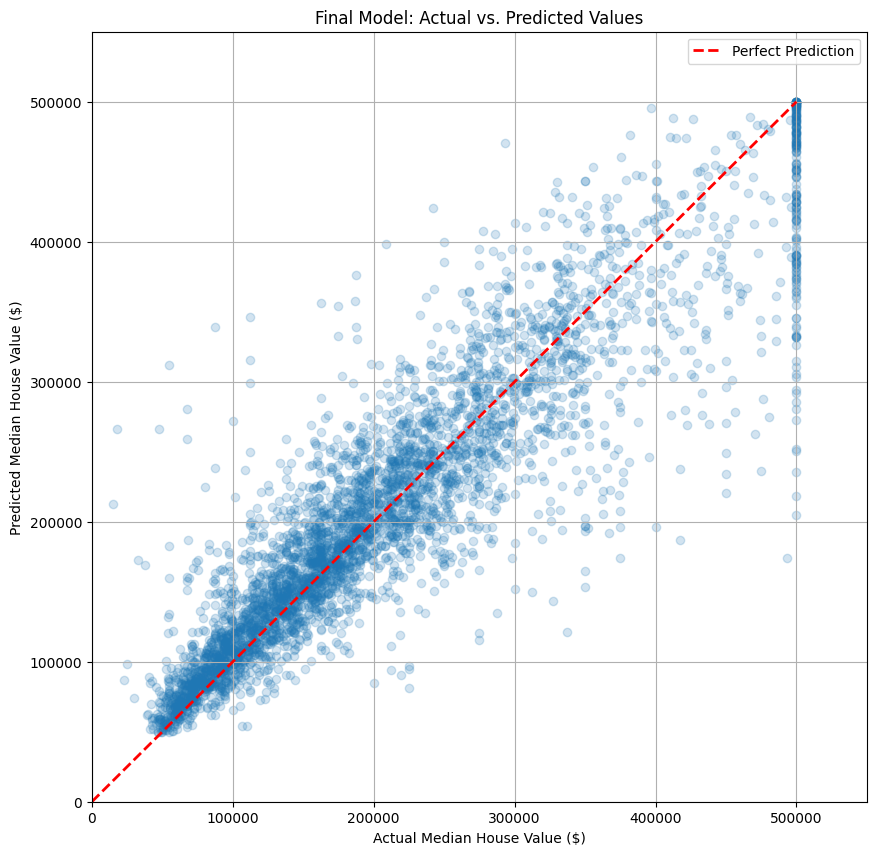

The model's predictions are clustered fairly tightly around the 'Perfect Prediction' line.


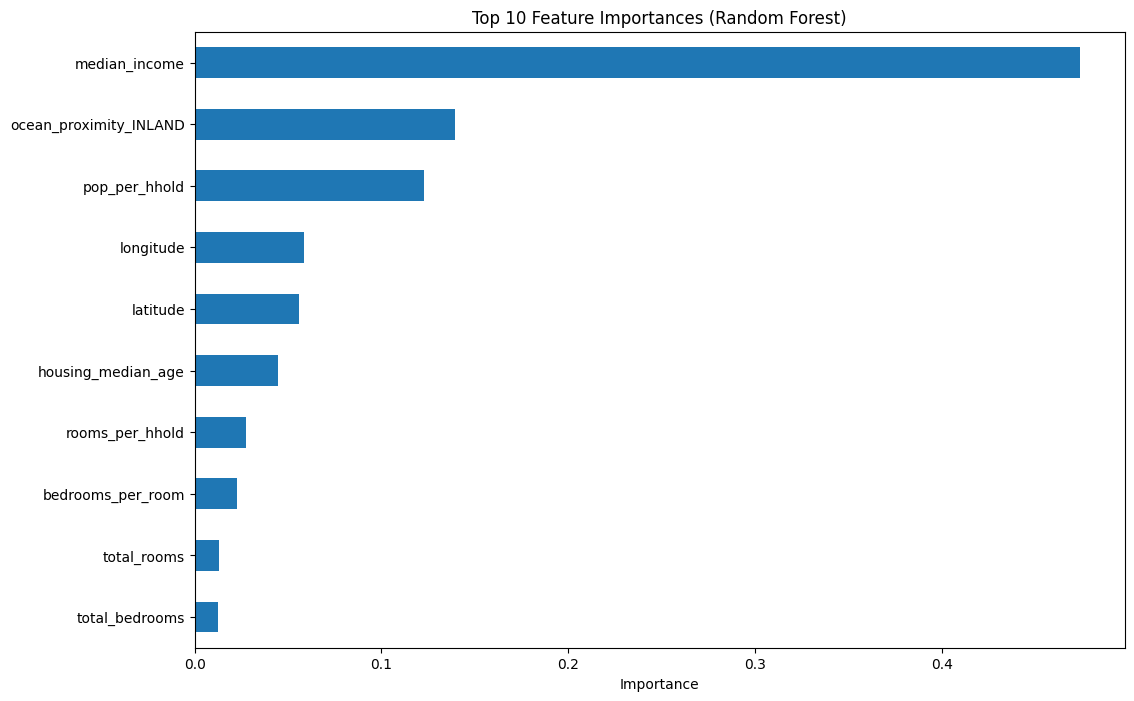


This shows 'median_income' and 'INLAND' (ocean_proximity) are key drivers.


In [3]:
# --- ADDED: VISUALIZE FINAL MODEL RESULTS ---

print("\n--- Visualizing Final Model Results ---")

# 1. Scatter plot of Predictions vs. Actual Values
# This is the best way to see how the model is performing.
plt.figure(figsize=(10, 10))
plt.scatter(y_test, final_predictions, alpha=0.2)
# Plot a 45-degree line (perfect prediction)
plt.plot([0, 500000], [0, 500000], 'r--', linewidth=2, label="Perfect Prediction")
plt.title("Final Model: Actual vs. Predicted Values")
plt.xlabel("Actual Median House Value ($)")
plt.ylabel("Predicted Median House Value ($)")
plt.axis([0, 550000, 0, 550000]) # Make axes equal
plt.legend()
plt.grid(True)
plt.show()
print("The model's predictions are clustered fairly tightly around the 'Perfect Prediction' line.")


# 2. Feature Importance
# This shows which features the Random Forest model found most useful.

# Get feature names from the pipeline
try:
    # Get original numerical feature names
    num_features = list(num_attribs)
    # Get engineered feature names
    num_features.extend(['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room'])
    # Get categorical (one-hot) feature names
    cat_features = full_pipeline.named_transformers_['cat'].get_feature_names_out(cat_attribs).tolist()
    # Combine all feature names
    all_features = num_features + cat_features

    # Get the importances from the final model
    importances = final_model.feature_importances_

    # Create a pandas Series for easy plotting
    feature_importance_series = pd.Series(importances, index=all_features)

    # Plot the top 10 features
    plt.figure(figsize=(12, 8))
    feature_importance_series.sort_values(ascending=False).head(10).sort_values().plot(kind='barh')
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.show()
    print("\nThis shows 'median_income' and 'INLAND' (ocean_proximity) are key drivers.")

except Exception as e:
    print(f"\nCould not generate feature importance plot: {e}")